# Análise exploratória de preços do Binance Coin (BNB/USDT)

Descrição resumida
- Script em Python para baixar OHLCV do par BNBUSDT da API da Binance, limpar e preparar os dados, calcular métricas/indicadores simples e gerar visualizações exploratórias.
- Etapas implementadas: coleta, limpeza, estatísticas descritivas, visualizações, correlação e feature engineering (médias móveis e volatilidade).

Dependências
- requests
- pandas
- numpy
- matplotlib
- seaborn

Instalação (exemplo)
```bash
pip install requests pandas numpy matplotlib seaborn
```

Principais funções/variáveis
- get_binance_ohlc(symbol="BNBUSDT", interval="1d", start=1493596800000, end=None)
    - Baixa candles (klines) da Binance e retorna DataFrame com colunas convertidas (datas e numéricos).
    - Parâmetro start em milissegundos (default começa em 2017).
- BNB_df
    - DataFrame final filtrado para ["open_time", "open", "high", "low", "close", "volume"] e ordenado por data.
    - Colunas adicionadas: `return` (pct_change), `SMA_7`, `SMA_30`, `volatilidade_7d`.

Outputs / Visualizações geradas
- Série temporal do preço de fechamento.
- Gráfico de volume diário.
- Histograma + KDE da distribuição dos retornos diários.
- Heatmap da matriz de correlação entre variáveis.
- Gráfico do preço com médias móveis (7d e 30d).
- Estatísticas descritivas impressas e contagem de linhas analisadas.

Observações importantes
- Requer conexão com a internet e acesso à API pública da Binance.
- Atenção a limites de taxa da API; para séries longas pagine chamadas ou implemente cache.
- O start padrão (1493596800000) é em ms; ajuste para período desejado.
- Valores NaN aparecem nas primeiras linhas ao calcular médias móveis e retornos (comportamento esperado).

Melhorias sugeridas
- Salvar o DataFrame em CSV/Parquet para análises futuras e evitar múltiplas chamadas.
- Implementar tratamento de exceções mais robusto e retry/backoff para requisições.
- Adicionar normalização, features adicionais (RSI, MACD) e pipeline para modelagem/forecast.
- Incluir argumentos CLI ou widgets para escolher período, símbolo e intervalo.

Licença
- Livre para uso/ajuste (adapte conforme necessidade do projeto).

In [11]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import time
import seaborn as sns

# ==============================
# Função para buscar TODOS os dados desde 2019
# ==============================
def get_full_binance_ohlc(symbol="BNBUSDT", interval="1d",
                          start_date="2019-01-01", end_date=None):
    url = "https://api.binance.com/api/v3/klines"
    start_timestamp = int(pd.Timestamp(start_date).timestamp() * 1000)
    end_timestamp = int(pd.Timestamp(end_date).timestamp() * 1000) if end_date else int(time.time() * 1000)

    all_data = []
    limit = 1000  # limite máximo por requisição

    while True:
        params = {
            "symbol": symbol,
            "interval": interval,
            "startTime": start_timestamp,
            "endTime": end_timestamp,
            "limit": limit
        }

        r = requests.get(url, params=params)
        r.raise_for_status()
        data = r.json()

        if not data:
            break

        all_data.extend(data)
        last_close_time = data[-1][6]  # coluna 'close_time'
        start_timestamp = last_close_time + 1  # próxima vela

        if start_timestamp >= end_timestamp:
            break

        time.sleep(0.2)  # evita limite de requisições da Binance

    cols = ["open_time", "open", "high", "low", "close", "volume",
            "close_time", "quote_volume", "num_trades",
            "taker_base_vol", "taker_quote_vol", "ignore"]

    df = pd.DataFrame(all_data, columns=cols)
    df["open_time"] = pd.to_datetime(df["open_time"], unit='ms')
    df["close_time"] = pd.to_datetime(df["close_time"], unit='ms')
    df[["open", "high", "low", "close", "volume"]] = \
        df[["open", "high", "low", "close", "volume"]].astype(float)

    return df

# ==============================
# Buscar dados completos (2019 até hoje)
# ==============================
BNB_df = get_full_binance_ohlc("BNBUSDT", "1d", "2019-01-01")

In [12]:
# ==============================
# Preparação e análise
# ==============================
BNB_df = BNB_df[["open_time", "open", "high", "low", "close", "volume"]]
BNB_df = BNB_df.sort_values("open_time").reset_index(drop=True)
BNB_df["return"] = BNB_df["close"].pct_change()

print(f"Período: {BNB_df['open_time'].min().date()} até {BNB_df['open_time'].max().date()}")
print("\nResumo estatístico:")
print(BNB_df.describe())

# ==============================
# LIMPEZA E PREPARAÇÃO
# ==============================
# Remover colunas desnecessárias
BNB_df = BNB_df[["open_time", "open", "high", "low", "close", "volume"]]

# Verificar valores nulos
print("Valores nulos:\n", BNB_df.isna().sum())

# Garantir que está ordenado por data
BNB_df = BNB_df.sort_values("open_time").reset_index(drop=True)

# Adicionar uma coluna de 'retorno diário'
BNB_df["return"] = BNB_df["close"].pct_change()

Período: 2019-01-01 até 2025-11-12

Resumo estatístico:
                 open_time         open         high          low  \
count                 2508  2508.000000  2508.000000  2508.000000   
mean   2022-06-07 12:00:00   321.231925   329.597705   312.239425   
min    2019-01-01 00:00:00     5.468800     5.888400     5.373300   
25%    2020-09-18 18:00:00    29.734025    30.660950    28.888600   
50%    2022-06-07 12:00:00   299.100000   306.500000   288.800000   
75%    2024-02-24 06:00:00   544.825000   559.325000   527.000000   
max    2025-11-12 00:00:00  1307.400000  1375.110000  1264.320000   
std                    NaN   262.915589   269.486745   255.978555   

             close        volume       return  
count  2508.000000  2.508000e+03  2507.000000  
mean    321.600718  1.474846e+06     0.003038  
min       5.468800  5.164829e+04    -0.441381  
25%      29.797325  3.527041e+05    -0.015396  
50%     299.185000  8.437887e+05     0.001758  
75%     545.150000  2.130635e+06  

In [13]:
# ==============================
# ESTATÍSTICAS DESCRITIVAS
# ==============================
print("\nResumo estatístico dos preços:")
print(BNB_df[["open", "high", "low", "close", "volume", "return"]].describe())


Resumo estatístico dos preços:
              open         high          low        close        volume  \
count  2508.000000  2508.000000  2508.000000  2508.000000  2.508000e+03   
mean    321.231925   329.597705   312.239425   321.600718  1.474846e+06   
std     262.915589   269.486745   255.978555   263.143183  1.684517e+06   
min       5.468800     5.888400     5.373300     5.468800  5.164829e+04   
25%      29.734025    30.660950    28.888600    29.797325  3.527041e+05   
50%     299.100000   306.500000   288.800000   299.185000  8.437887e+05   
75%     544.825000   559.325000   527.000000   545.150000  2.130635e+06   
max    1307.400000  1375.110000  1264.320000  1307.400000  2.018886e+07   

            return  
count  2507.000000  
mean      0.003038  
std       0.045425  
min      -0.441381  
25%      -0.015396  
50%       0.001758  
75%       0.019777  
max       0.703021  


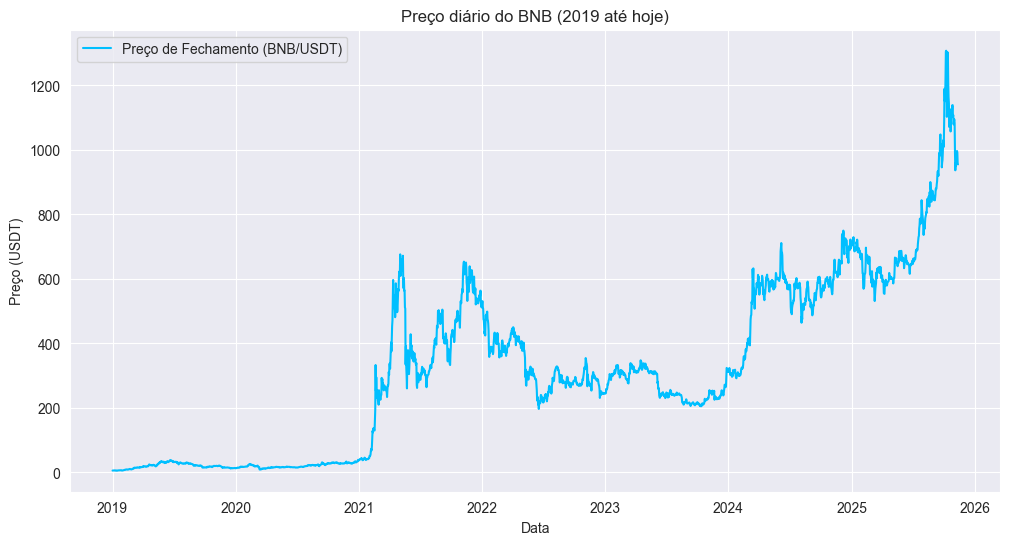

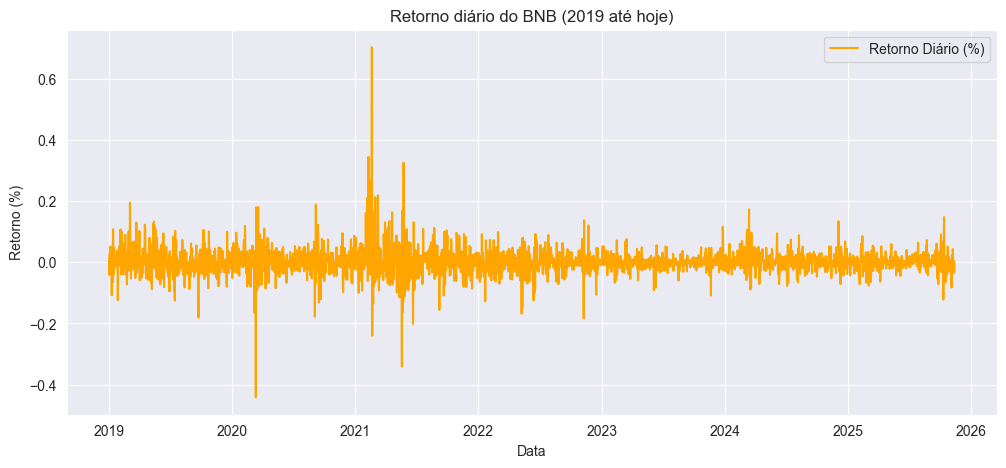

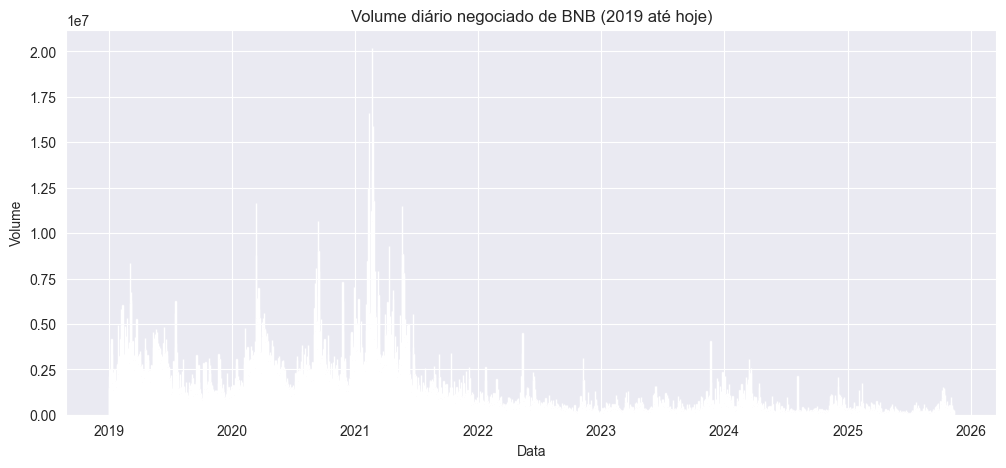

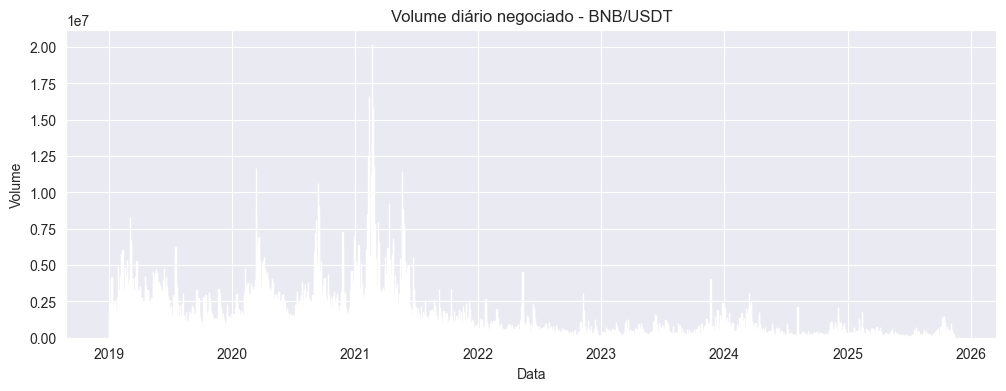

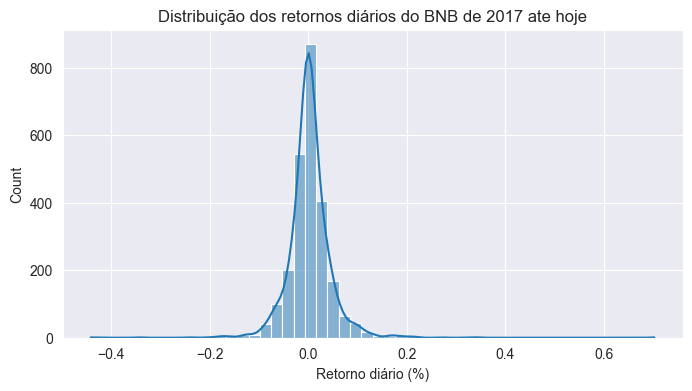

In [14]:
# ==============================
# Gráfico de preço
# ==============================
plt.figure(figsize=(12,6))
plt.plot(BNB_df["open_time"], BNB_df["close"], label="Preço de Fechamento (BNB/USDT)", color="deepskyblue")
plt.title("Preço diário do BNB (2019 até hoje)")
plt.xlabel("Data")
plt.ylabel("Preço (USDT)")
plt.legend()
plt.grid(True)
plt.show()


# Gráfico 2: Retornos diários
plt.figure(figsize=(12,5))
plt.plot(BNB_df["open_time"], BNB_df["return"], color='orange', label="Retorno Diário (%)")
plt.title("Retorno diário do BNB (2019 até hoje)")
plt.xlabel("Data")
plt.ylabel("Retorno (%)")
plt.legend()
plt.grid(True)
plt.show()

# Gráfico 3: Volume negociado
plt.figure(figsize=(12,5))
plt.bar(BNB_df["open_time"], BNB_df["volume"], color='purple')
plt.title("Volume diário negociado de BNB (2019 até hoje)")
plt.xlabel("Data")
plt.ylabel("Volume")
plt.grid(True)
plt.show()


# Volume negociado
plt.figure(figsize=(12,4))
plt.bar(BNB_df["open_time"], BNB_df["volume"], color="orange")
plt.title("Volume diário negociado - BNB/USDT")
plt.xlabel("Data")
plt.ylabel("Volume")
plt.show()

# Distribuição dos retornos
plt.figure(figsize=(8,4))
sns.histplot(BNB_df["return"].dropna(), bins=50, kde=True)
plt.title("Distribuição dos retornos diários do BNB de 2017 ate hoje")
plt.xlabel("Retorno diário (%)")
plt.show()


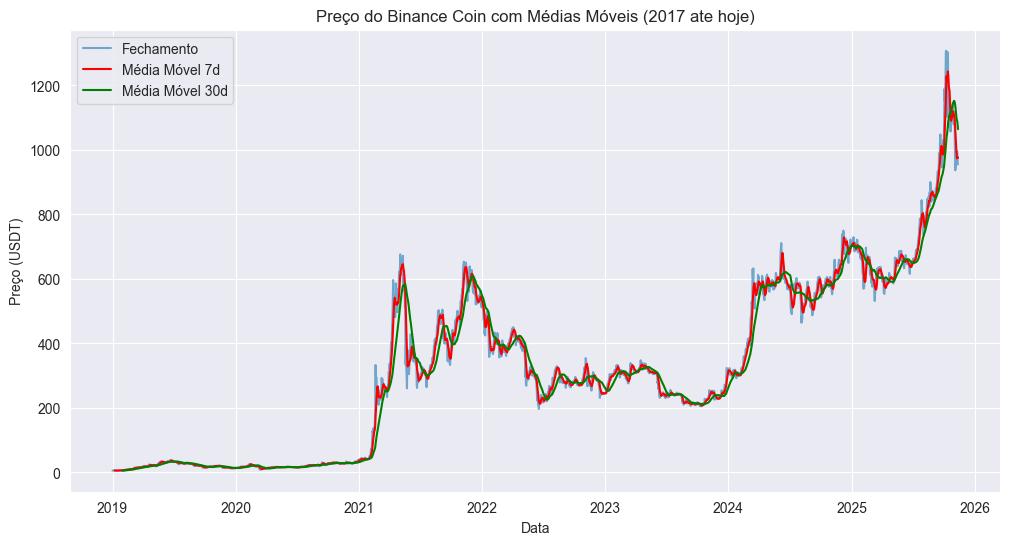

In [15]:
# ==============================
# FEATURE ENGINEERING (para predição futura)
# ==============================
# Médias móveis (tendência)
BNB_df["SMA_7"] = BNB_df["close"].rolling(window=7).mean()   # 1 semana
BNB_df["SMA_30"] = BNB_df["close"].rolling(window=30).mean() # 1 mês

# Volatilidade (desvio padrão dos retornos)
BNB_df["volatilidade_7d"] = BNB_df["return"].rolling(window=7).std()

# Gráfico com médias móveis
plt.figure(figsize=(12,6))
plt.plot(BNB_df["open_time"], BNB_df["close"], label="Fechamento", alpha=0.6)
plt.plot(BNB_df["open_time"], BNB_df["SMA_7"], label="Média Móvel 7d", color="red")
plt.plot(BNB_df["open_time"], BNB_df["SMA_30"], label="Média Móvel 30d", color="green")
plt.title("Preço do Binance Coin com Médias Móveis (2017 ate hoje)")
plt.xlabel("Data")
plt.ylabel("Preço (USDT)")
plt.legend()
plt.grid(True)
plt.show()


In [16]:
# ==============================
# Resultado final
# ==============================
print("Análise exploratória concluída com sucesso!")
print("Linhas analisadas:", len(BNB_df))
BNB_df.tail()


Análise exploratória concluída com sucesso!
Linhas analisadas: 2508


,open_time,open,high,low,close,volume,return,SMA_7,SMA_30,volatilidade_7d
2503,2025-11-08,991.14,1007.41,980.05,991.03,301705.689,-0.000121,986.495714,1095.390667,0.043791
2504,2025-11-09,991.01,1007.16,975.84,996.63,256660.748,0.005651,974.121429,1091.862667,0.044381
2505,2025-11-10,996.63,1019.56,976.22,991.98,281128.796,-0.004666,973.898571,1087.093000,0.031154
2506,2025-11-11,991.99,1008.60,956.08,958.08,283951.869,-0.034174,976.942857,1075.607333,0.024637
2507,2025-11-12,958.08,978.61,937.90,955.16,213687.480,-0.003048,976.347143,1064.294333,0.022930
